In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

In [15]:
# Путь к датасету
candidates = [
    Path("S05-hw-dataset.csv"),
    Path("seminars/S05/S05-hw-dataset.csv"),
    Path("../../seminars/S05/S05-hw-dataset.csv"),
]

data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("Cannot find S05-hw-dataset.csv via relative paths")

df = pd.read_csv(data_path)
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [16]:
# Мини-EDA
display(df.head())
df.info()
display(df.describe())

target_share = df["default"].value_counts(normalize=True)
display(target_share)

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [17]:
# X / y
y = df["default"].astype(int)

X = df.drop(columns=["default", "client_id"], errors="ignore")

# быстрый чек: все признаки числовые
non_numeric = X.select_dtypes(exclude="number").columns.tolist()
non_numeric

[]

In [18]:
# Train/Test split + бейзлайн DummyClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)
dummy_proba = dummy.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, dummy_pred)
dummy_auc = roc_auc_score(y_test, dummy_proba)

dummy_acc, dummy_auc

(0.5893333333333334, 0.5)

In [19]:
# Логистическая регрессия + подбор C
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000)),
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0],
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

({'logreg__C': 1.0}, np.float64(0.8631695636003741))

In [20]:
# Оценка лучшей модели
best_model = grid.best_estimator_

lr_pred = best_model.predict(X_test)
lr_proba = best_model.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_proba)

lr_acc, lr_auc

(0.7933333333333333, 0.8647088205911735)

In [21]:
# Сравнение моделей в таблице
results = pd.DataFrame([
    {"model": "Dummy(most_frequent)", "accuracy": dummy_acc, "roc_auc": dummy_auc},
    {"model": "LogReg(best C)",       "accuracy": lr_acc,    "roc_auc": lr_auc},
])
results

,model,accuracy,roc_auc
0,Dummy(most_frequent),0.589333,0.500000
1,LogReg(best C),0.793333,0.864709


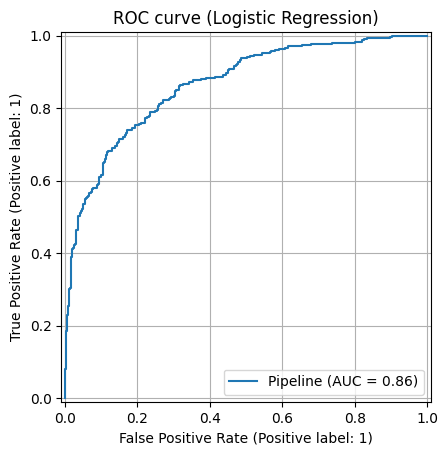

WindowsPath('figures/roc_logreg.png')

In [22]:
# ROC-кривая и сохранение в figures
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC curve (Logistic Regression)")
plt.grid(True)

out_path = fig_dir / "roc_logreg.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

out_path

In [ ]:
# Выводы: Бейзлайн Dummy(most_frequent) даёт accuracy ≈ 0.589 и ROC-AUC = 0.5, т.е. фактически не различает классы и служит точкой отсчёта. Логистическая регрессия после стандартизации признаков заметно улучшает качество: accuracy ≈ 0.793 и ROC-AUC ≈ 0.865. Подбор C показал, что лучшее значение C=1.0, при нём достигается максимальный ROC-AUC на кросс-валидации. ROC-кривая подтверждает способность модели отделять класс дефолта от недефолта. Для этой задачи логистическая регрессия выглядит разумным базовым решением: она простая, интерпретируемая и значительно лучше бейзлайна. Дальше можно улучшать качество через подбор порога, PR-кривую и дополнительные модели.